__Radial Distribution Function__

    - calculate the RDF from the coordinates of a molecular dynamics simulation.
    - written for DL-POLY output file but can easily be used (with some modifications) for any other simulation software
    - code has been written in a parallel implementation and can be run in Pittsburgh Supercomputer 
    - reach out if you need help with anything in the code.
    
### Author: Rajendra Thapa


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from tqdm import tqdm

In [7]:
from multiprocessing import Pool

def distance(atom, nbd, box):
    ''' Faster way to calculate the distance of atoms from a reference atom.
        
        Inputs: atom = coordinate of the atom being considered
                nbd = all the atoms whose distances from "atom" are being calculated
                box = box_size
        Output: dis = list of distances, len(dist) == len(nbd)
                
    '''
    delta = np.abs(atom-nbd)
    delta = np.where(delta> 0.5*box, delta-box, delta)
    dis = np.sqrt((delta**2).sum(axis=-1))
    return dis

def calculate_rdf_chunk(args):
    chunk, positions, box_size, dr, max_distance = args
    n_atoms = len(positions)
    n_bins = int(max_distance / dr)
    rdf_chunk = np.zeros(n_bins)
    
    for i in chunk:
        nbd = positions[i:n_atoms][:]
        dist = distance(positions[i][:], positions[i:][:],box_size)
        for ind1 in range(len(dist)):
            if dist[ind1] < max_distance and dist[ind1] != 0.0:
                ct = int(dist[ind1]/dr)
                rdf_chunk[ct-1] += 2    
    return rdf_chunk

def rdf_parallel(positions, box_size, dr, max_distance, num_processes=128):
    n_atoms = len(positions)
    chunk_size = int(np.ceil(n_atoms / num_processes))
    chunks = [range(i, min(i + chunk_size, n_atoms)) for i in range(0, n_atoms, chunk_size)]
    
    with Pool(num_processes) as pool:
        args = [(chunk, positions, box_size, dr, max_distance) for chunk in chunks]
        results = list(pool.imap_unordered(calculate_rdf_chunk, args))
    
    rdf_values = np.sum(results, axis=0)
    
    rho = n_atoms / (box_size**3)
    shell_volume = 4 * np.pi * (np.arange(len(rdf_values)) * dr)**2 * dr
    normalization = rho * n_atoms * shell_volume
    rdf_values /= normalization
    
    return rdf_values

In [8]:
def get_coords(lines):
    seed_rad = 15.0
    coords = []
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith(("Li1+", "Nb5+", "O2-")):
            if i + 1 < len(lines):
                tmp = [float(item) for item in lines[i+1].split()]
    # Doing this because I have a crystal seed in the center which I don't want to go into the RDF calculation.
    # In most cases, this step is redundant
                if tmp[0]**2+tmp[1]**2+tmp[2]**2 > (seed_rad - 1.0)**2:
                    coords.append(lines[i + 1].split())
    return np.array([[float(num) for num in row] for row in coords])

In [13]:
import pickle
def main():
    _dir = "/ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON"
    rdf_data = {}
    for MQ_steps in range(1,13):
        for run_type in ["nve"]:#,"nve"]:   # NVT was followed by NVE in the MQ cycle
            f_name = f"{_dir}/15A_W0-{MQ_steps}-{run_type}.rcn"
            print("Working on ",f_name)
            with open(f_name) as file:
                lines = file.readlines()
            Lx, Ly, Lz = float(lines[2].split()[0]), float(lines[3].split()[1]), float(lines[4].split()[2])
            xyz_coords = get_coords(lines)
            dr = 0.02
            rdf_data[MQ_steps] = rdf_parallel(xyz_coords, Lx, dr, 0.5*Lx)

            # rdf_data[MQ_steps] = rdf_values  # MQ_steps as the key
    
    # Save the dictionary to a file
        with open("rdf_data.pickle", "wb") as f:
            pickle.dump(rdf_data, f)
        

In [14]:
if __name__ == "__main__":
    main()

Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-1-nve.rcn


/var/tmp/ipykernel_17127/3951775126.py:46: RuntimeWarning: invalid value encountered in true_divide
  rdf_values /= normalization


Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-2-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-3-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-4-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-5-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-6-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-7-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-8-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-9-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/MQ_REVCON/15A_W0-10-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns

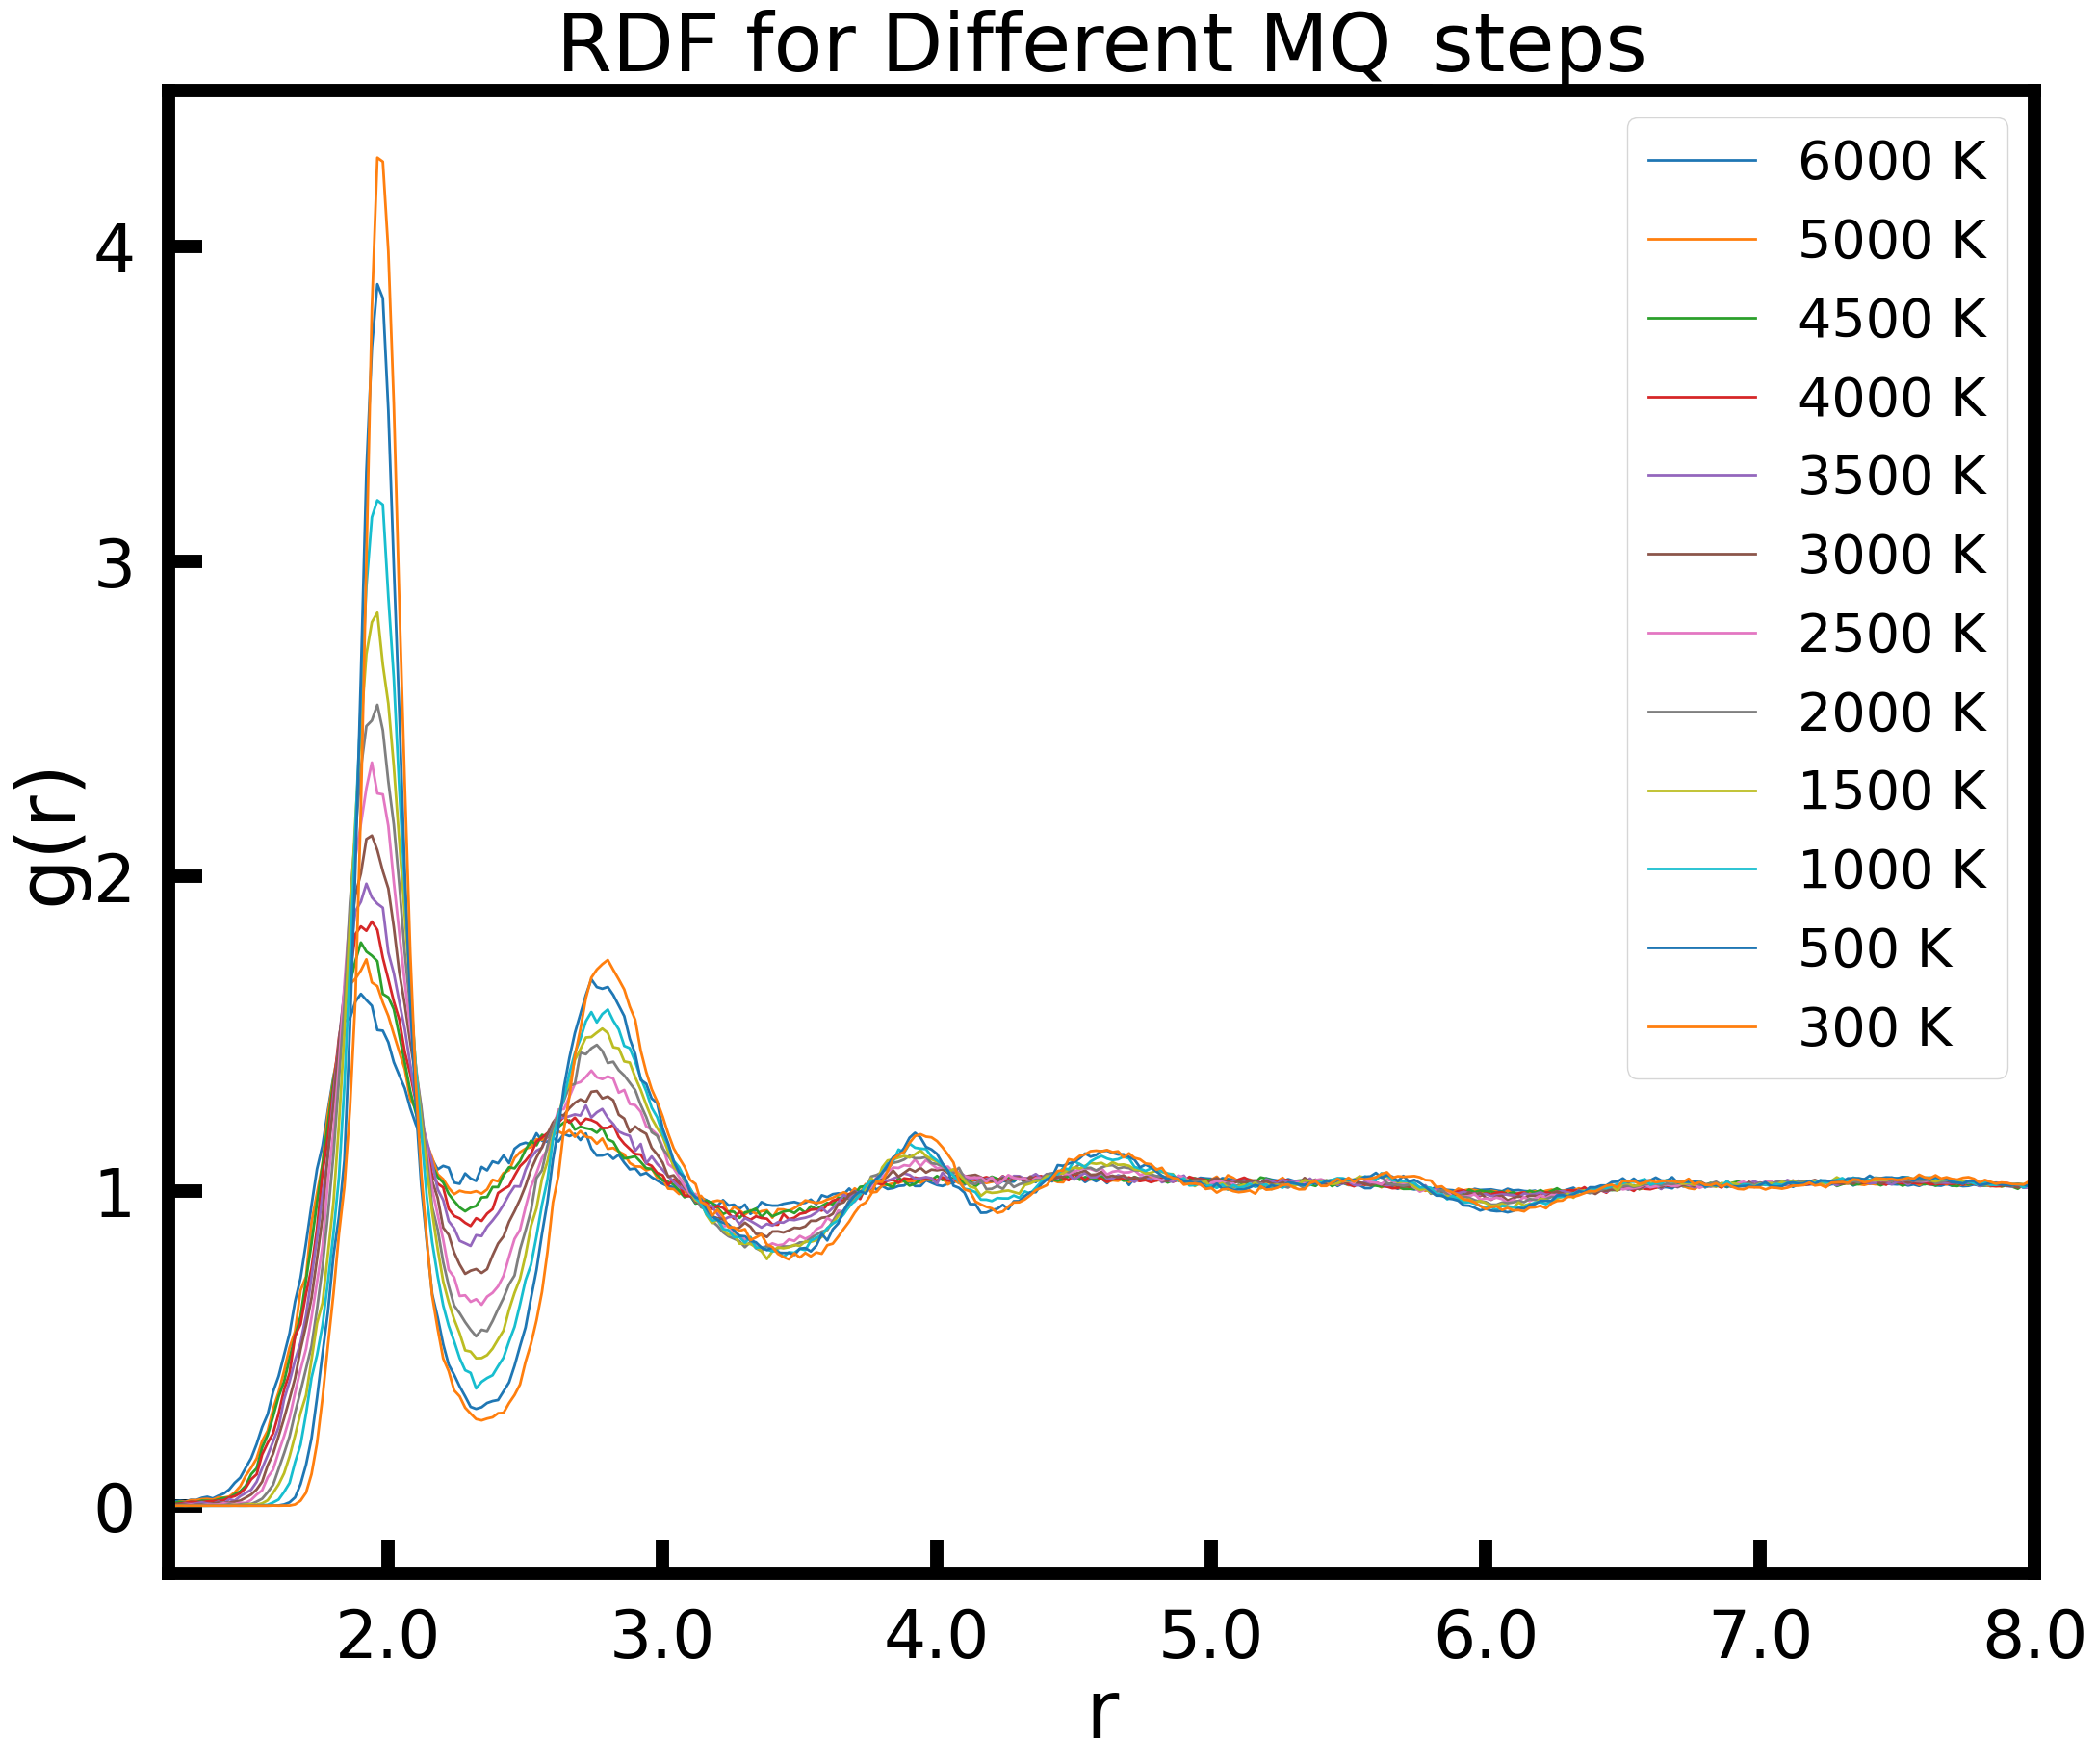

In [27]:
import pickle
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.size'] = 40
plt.rcParams['axes.labelsize'] = 60
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 60
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=2.0
plt.rcParams['figure.figsize'] = 25,20#width,height
plt.rcParams['lines.markersize']=5
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=25
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=25
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'


def plot_rdf_from_pickle(pickle_file):
    with open(pickle_file, 'rb') as f:
        rdf_data = pickle.load(f)
    # Define mapping between old keys (1 to 12) and new keys (6000 to 300)
    key_mapping = {1: 6000, 2: 5000, 3: 4500, 4: 4000, 5: 3500, 6: 3000, 7: 2500, 8: 2000, 9: 1500, 10: 1000, 11: 500, 12: 300}

    # Update keys in the dictionary
    rdf_data = {key_mapping[key]: value for key, value in rdf_data.items()}
    for MQ_steps, rdf_values in rdf_data.items():
        plt.plot(rdf_values, label=f"{MQ_steps} K")

    plt.legend(loc='best')
    plt.xlim(60,400)
    plt.xlabel('r')
    plt.ylabel('g(r)')
    # Customize x-axis labels
    x_ticks = [100, 150, 200, 250, 300, 350, 400]  # Custom positions for x-axis ticks
    x_labels = ['2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0']  # Custom labels for x-axis ticks
    plt.xticks(x_ticks, x_labels)
    plt.title('RDF for Different MQ_steps')
    plt.show()

# Call the function with the path to your pickle file
plot_rdf_from_pickle("rdf_data.pickle")